# Descendent gradient 
Implementation from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import random
import functools

## Dataset 
The dataset consist in a not-sorted set of pairs $\{x_i, y_i\}$

In [2]:


def sort_by_col(mat, i):
    return mat[mat[:, i].argsort()]


points = np.genfromtxt("data.csv", delimiter=",")
print(points.shape)
points = sort_by_col(points, 0)

(100, 2)


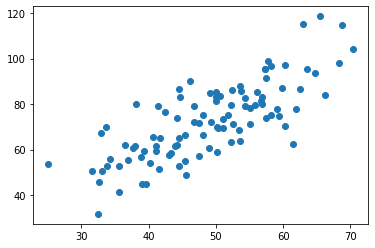

In [3]:
plt.scatter(points[:, 0], points[:, 1])
plt.show()

# Implementation and use of the gradient
We compute the gradient of a function $f(x_0, \dots, x_{n-1}$ by using the definition of the partial derivative

$$ \frac{\partial f}{\partial x_i} = \lim_{h\rightarrow 0} 
\frac{f(x_0, \dots,x_i + h, \dots, x_{n-1}) - f(x_0, \dots, x_{n-1})}{h} $$

We just make $h \rightarrow 0$ .

In [4]:
def partial_derivative_quotient(f, v, i, h):
    w = np.array([v_j + (h if i == j else 0) for j, v_j in enumerate(v)])
    return (f(w) - f(v)) / h

def estimate_gradient(f, v, h=0.00001):
    return np.array([partial_derivative_quotient(f, v, i, h) 
                     for i, _ in enumerate(v)])

In [5]:
def f(v):
    x, y = v[0], v[1]
    return x**2 + y**2

def df(v):
    x, y = v[0], v[1]
    return np.array([2*x, 2*y])


v = [random.randint(-10, 10) for _ in range(2)]
print(f'v = {v}')
print(f'f(v) = {f(v)}')
print(f'df(v) = {df(v)}')
print(f'df(v) (by limit) = {estimate_gradient(f, v)}')


v = [9, -1]
f(v) = 82
df(v) = [18 -2]
df(v) (by limit) = [18.00001 -1.99999]


## Descendent gradient

In particular for the mse for linear regression we have
$$ 
\begin{align}
    MSE_\Theta = \frac{1}{m}\sum_i (y_i - h_\theta(x_i))^2 \\
               = \frac{1}{m}\sum_i (y_i - \theta_0 - \theta_1 x_i )^2  
\end{align}
$$

$$
\begin{align}
    \nabla_{\theta_j} MSE = -\frac{2}{m}\sum_i(y_i - h_\theta(x_i)) x_j
\end{align}
$$
 
We can plug this equation to compute the gradient, however we'll prove our gradient estimation works.

In [6]:

def safe(f, *args, **kwargs):
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')
    return safe_f

def descendent_gradient(target_fn, gradient_fn,  theta_0, 
                        lr=0.001, tol=0.001, max_iter=1000):
    '''target_fn returns the error for the entire dataset'''
    theta = theta_0
    value = target_fn(theta)
    for epoch in range(max_iter):
        theta = theta - lr*gradient_fn(theta)
        next_v = target_fn(theta)
        if abs(value - next_v) < tol:
            return theta
        value = next_v
    print('MAX ITER REACHED')
    return theta  # max iterations reached

def mse(theta, x, y):
    return sum((y_i - theta.dot(x_i)) ** 2 for x_i, y_i in zip(x, y)) / len(x)

In [7]:
X, y = points[:, 0], points[:, 1]

# add bias to X
m = len(X)
one_column = np.ones((m, 1))
X_with_bias = np.c_[one_column, X]
print(X_with_bias.shape)
print(X_with_bias[:5])

(100, 2)
[[ 1.         25.12848465]
 [ 1.         31.588117  ]
 [ 1.         32.50234527]
 [ 1.         32.66904376]
 [ 1.         32.94047994]]


In [8]:
theta_0 = np.array([random.randint(-10, 10) for _ in range(2)])
loss = functools.partial(mse, x=X_with_bias, y=y)
loss(theta_0)

34163.64251510339

In [9]:
grad_loss = functools.partial(estimate_gradient, loss)
grad_loss(theta_0)

array([  362.11332263, 18420.18397001])

In [10]:
%time theta_update = descendent_gradient(loss, grad_loss, theta_0, lr=0.00001, tol=0.000001, max_iter=10000)

CPU times: user 166 ms, sys: 3.73 ms, total: 170 ms
Wall time: 169 ms


In [11]:
print(f'loss({theta_update}) = {loss(theta_update)}')

loss([8.92720625 1.30408476]) = 110.2904793075699


In [12]:
y_pred = [theta_update.dot(x) for x in X_with_bias]
print(y[:5])
print(y_pred[:5])

[53.45439421 50.39267014 31.70700585 45.57058882 67.17065577]
[41.69688022982846, 50.12078836126562, 51.31301952103652, 51.53040848732123, 51.88438427304682]


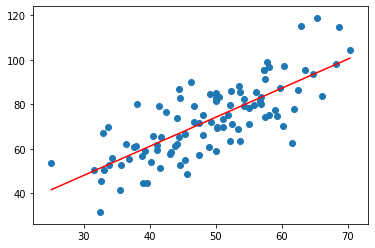

In [13]:

def plot_model(X, y, y_pred):
    plt.plot()
    plt.plot(X, y_pred, color='red')
    plt.scatter(X, y)
    plt.show()

    
plot_model(X, y, y_pred)

Sometimes we’ll instead want to maximize a function, which we can do by minimiz‐
ing its negative.

In [14]:
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
            negate_all(gradient_fn),
            theta_0,
            tolerance)

## Stochastic gradient descent

computes the gradient (and takes a step) for only one point at a time.
It cycles over our data repeatedly until it reaches a stopping point.

In [15]:
def in_random_order(x, y):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(x)]  # create a list of indexes
    random.shuffle(indexes)
    for i in indexes:
        yield x[i], y[i]
        
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    theta = theta_0
    alpha = alpha_0
    min_theta, min_value = None, float("inf")
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in zip(x, y) )
        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(x, y):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = theta - alpha*gradient_i  # vector_subtract(theta, scalar_multiply(alpha, gradient_i))
    return min_theta

Compute the gradient per each point, in practice we should divide the gradient by the size of the dataset in order to avoid overflow. The election of the most optimal hyperparameters is easier with this approach.

In [16]:
m = len(X_with_bias)


def grad_mse_j(x_i, y_i, theta, j):
    return -2*(y_i - theta.dot(x_i))* x_i[j] / m

def grad_mse(x_i, y_i, theta):
    return np.array([grad_mse_j(x_i, y_i, theta, j) for j, _ in enumerate(theta)])

def err_fn(x_i, y_i, theta):
    return (y_i - theta.dot(x_i))**2 / m

In [17]:
%time theta_0 = np.array([random.randint(-10, 10) for _ in X_with_bias[0]])
theta_hat = minimize_stochastic(err_fn, grad_mse, X_with_bias, y, theta_0)

CPU times: user 53 µs, sys: 5 µs, total: 58 µs
Wall time: 63.4 µs


In [18]:
print(theta_hat)

[7.8620928  1.32501848]


In [19]:
loss(theta_hat)

110.25801813754236

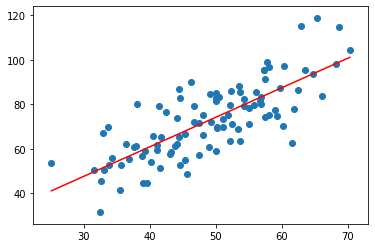

In [20]:
def predict(theta, X):
    return [theta.dot(x) for x in X]

y_pred = predict(theta_hat, X_with_bias)
plot_model(X, y, y_pred)